In [83]:
import s3fs
import xarray as xr
import metpy
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cartopy.feature as cfeature
import numpy as np


from metpy.plots import USCOUNTIES
%matplotlib inline


In [ ]:
#https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/xarray_one_day_analysis_example.html

In [84]:

def nearest_points(ds, points, names=None, verbose=True):
    """
    Get the nearest latitude/longitude points from a xarray Dataset.
    This is **much** faster than my old "pluck_points" method. For
    matchign 1,948 points,
    - `nearest_points` completed in 7.5 seconds.
    - `pluck_points` completed in 2 minutes.
    Info
    ----
    - Stack Overflow: https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    - MetPy Details: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x
    Parameters
    ----------
    ds : a friendly xarray Dataset
    points : tuple (lon, lat) or list of tuples
        The longitude and latitude (lon, lat) coordinate pair (as a tuple)
        for the points you want to pluck from the gridded Dataset.
        A list of tuples may be given to return the values from multiple points.
    names : list
        A list of names for each point location (i.e., station name).
        None will not append any names. names should be the same
        length as points.
    """
    # Check if MetPy has already parsed the CF metadata grid projection.
    # Do that if it hasn't been done yet.
    if 'metpy_crs' not in ds:
        ds = ds.metpy.parse_cf()

    # Apply the MetPy method `assign_y_x` to the dataset
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.xarray.html?highlight=assign_y_x#metpy.xarray.MetPyDataArrayAccessor.assign_y_x
    ds = ds.metpy.assign_y_x(force=True)

    # Convert the requested [(lon,lat), (lon,lat)] points to map projection.
    # Accept a list of point tuples, or Shapely Points object.
    # We want to index the dataset at a single point.
    # We can do this by transforming a lat/lon point to the grid location
    crs = ds.metpy_crs.item().to_cartopy()
    # lat/lon input must be a numpy array, not a list or polygon
    if isinstance(points, tuple):
        # If a tuple is give, turn into a one-item list.
        points = np.array([points])
    if not isinstance(points, np.ndarray):
        # Points must be a 2D numpy array
        points = np.array(points)
    lons = points[:,0]
    lats = points[:,1]
    transformed_data = crs.transform_points(ccrs.PlateCarree(), lons, lats)
    xs = transformed_data[:,0]
    ys = transformed_data[:,1]

    # Select the nearest points from the projection coordinates.
    # TODO: Is there a better way?
    # There doesn't seem to be a way to get just the points like this
    #ds = ds.sel(x=xs, y=ys, method='nearest')
    # because it gives a 2D array, and not a point-by-point index.
    # Instead, I have too loop the ds.sel method
    new_ds = xr.concat([ds.sel(x=xi, y=yi, method='nearest') for xi, yi in zip(xs, ys)], dim='point')

    # Add list of names as a coordinate
    if names is not None:
        # Assign the point dimension as the names.
        assert len(points) == len(names), '`points` and `names` must be same length.'
        new_ds['point'] = names

    return new_ds



In [ ]:
date = '20220108'
hour = '12'
var = 'TMP'
level = '2m_above_ground'
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_anl.zarr/' + level + '/' + var
print(url1)
print(url2)

In [ ]:
fs = s3fs.S3FileSystem(anon=True)
file1 = s3fs.S3Map(url1, s3=fs)
file2 = s3fs.S3Map(url2, s3=fs)

In [ ]:
ds = xr.open_mfdataset([file1,file2], engine='zarr')


In [ ]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds

In [ ]:
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

In [ ]:
ds = load_combined_dataset(datetime.datetime(2024, 1, 8), 12, "surface", "ASNOW_acc_fcst")

In [ ]:
ds

In [ ]:
fm = plt.figure(figsize=[20,10])
ax = plt.axes(projection=ccrs.PlateCarree())
p = ds.ASNOW_acc_fcst[-1].plot( transform=ccrs.PlateCarree(), ax=ax, cmap=plt.cm.coolwarm)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

plt.ylim(41,43.)
plt.xlim(-89,-87)
ax.add_feature(USCOUNTIES.with_scale('20m'))


In [17]:
import dataclasses
import datetime

@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id

In [90]:
level_type = "sfc"
model_type = "fcst"
run_hour = datetime.datetime(2024, 1, 8, 18)

def create_hrrr_zarr_explorer_url(level_type, model_type, run_hour):
    url = "https://hrrrzarr.s3.amazonaws.com/index.html"
    url += run_hour.strftime(
        f"#{level_type}/%Y%m%d/%Y%m%d_%Hz_{model_type}.zarr/")
    return url

print(create_hrrr_zarr_explorer_url(level_type, model_type, run_hour))
print(create_hrrr_zarr_explorer_url("prs", "anl", run_hour))
zarr_id = ZarrId(
                run_hour=run_hour, # Aug 1, 0Z
                level_type="sfc",
                var_level="surface",
                var_name="ASNOW_acc_fcst",
                model_type="fcst"
                )
chunk_id = "4.3"

def create_https_chunk_url(zarr_id, chunk_id):
    url = "https://hrrrzarr.s3.amazonaws.com"
    url += zarr_id.run_hour.strftime(
        f"/{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}/{zarr_id.var_level}/{zarr_id.var_name}"
    url += f"/{zarr_id.format_chunk_id(chunk_id)}"
    return url

create_https_chunk_url(zarr_id, chunk_id)

https://hrrrzarr.s3.amazonaws.com/index.html#sfc/20240108/20240108_18z_fcst.zarr/
https://hrrrzarr.s3.amazonaws.com/index.html#prs/20240108/20240108_18z_anl.zarr/


'https://hrrrzarr.s3.amazonaws.com/sfc/20240108/20240108_18z_fcst.zarr/surface/ASNOW_acc_fcst/surface/ASNOW_acc_fcst/0.4.3'

In [91]:
def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

create_s3_group_url(zarr_id)

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

create_s3_subgroup_url(zarr_id)

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

create_s3_chunk_url(zarr_id, chunk_id)

'sfc/20240108/20240108_18z_fcst.zarr/surface/ASNOW_acc_fcst/surface/ASNOW_acc_fcst/0.4.3'

In [92]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

In [93]:
def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)    
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    
    # add the projection data
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()    
    return ds

ds = load_dataset([create_s3_group_url(zarr_id), create_s3_subgroup_url(zarr_id)])

In [94]:
ds

<xarray.Dataset>
Dimensions:                  (time_2: 45, y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 -2.698e+06 -2.695e+06 ... 2.696e+06
  * y                        (y) float64 -1.587e+06 -1.584e+06 ... 1.587e+06
  * time_2                   (time_2) datetime64[ns] 2024-01-08T20:00:00 ... ...
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 (y, x) float64 21.14 21.15 21.15 ... 47.85 47.84
    longitude                (y, x) float64 -122.7 -122.7 ... -60.95 -60.92
Data variables:
    ASNOW_acc_fcst           (time_2, y, x) float16 dask.array<chunksize=(45, 150, 150), meta=np.ndarray>
    forecast_period_2        (time_2) datetime64[ns] dask.array<chunksize=(45,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

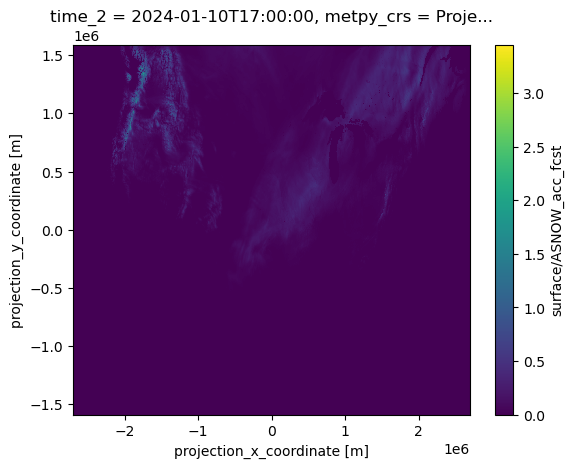

In [95]:
ds.ASNOW_acc_fcst[-1].plot()

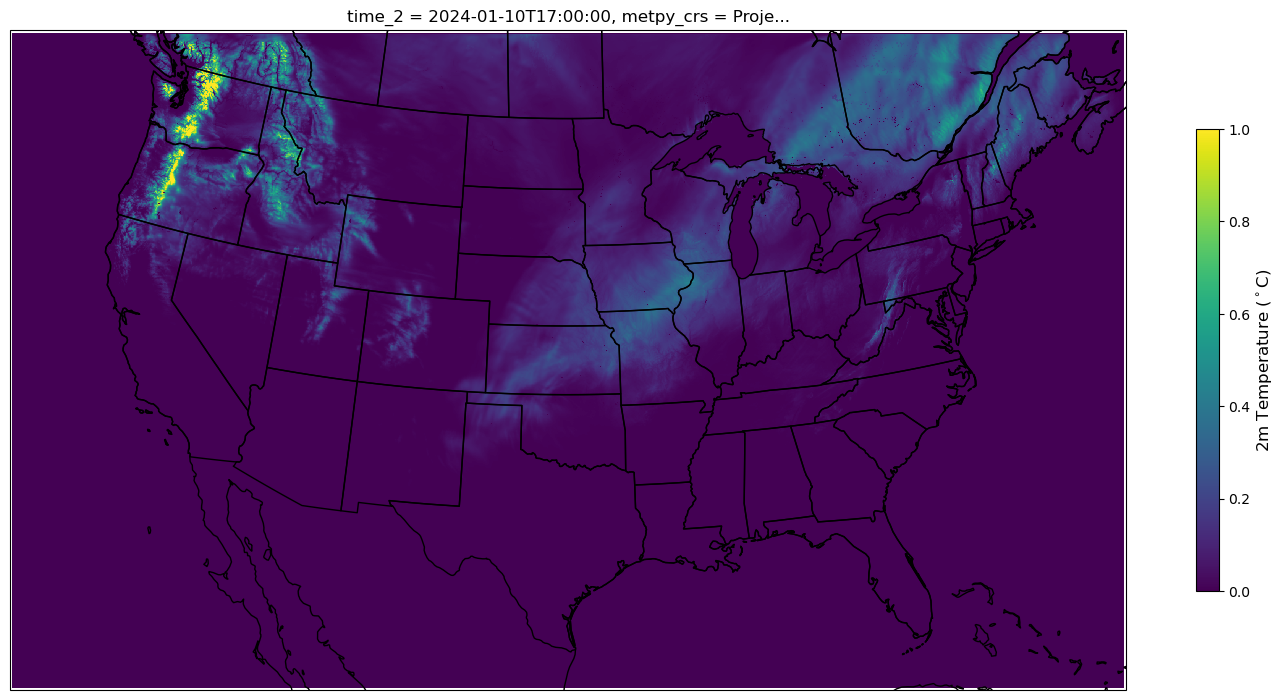

In [96]:
latN = 50.4
latS = 24.25
lonW = -123.8
lonE = -71.2

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
#tl1 = str('HRRR 2m temperature ($^\circ$C)')
#tl2 = str('Analysis valid at: '+ hour + '00 UTC ' + date  )
#plt.title(tl1+'\n'+tl2,fontsize=16)

# Contour fill
CF = ds.ASNOW_acc_fcst[-1].plot(add_colorbar=False, vmin = 0, vmax=1)


# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label(r'2m Temperature ($^\circ$C)', size='large')

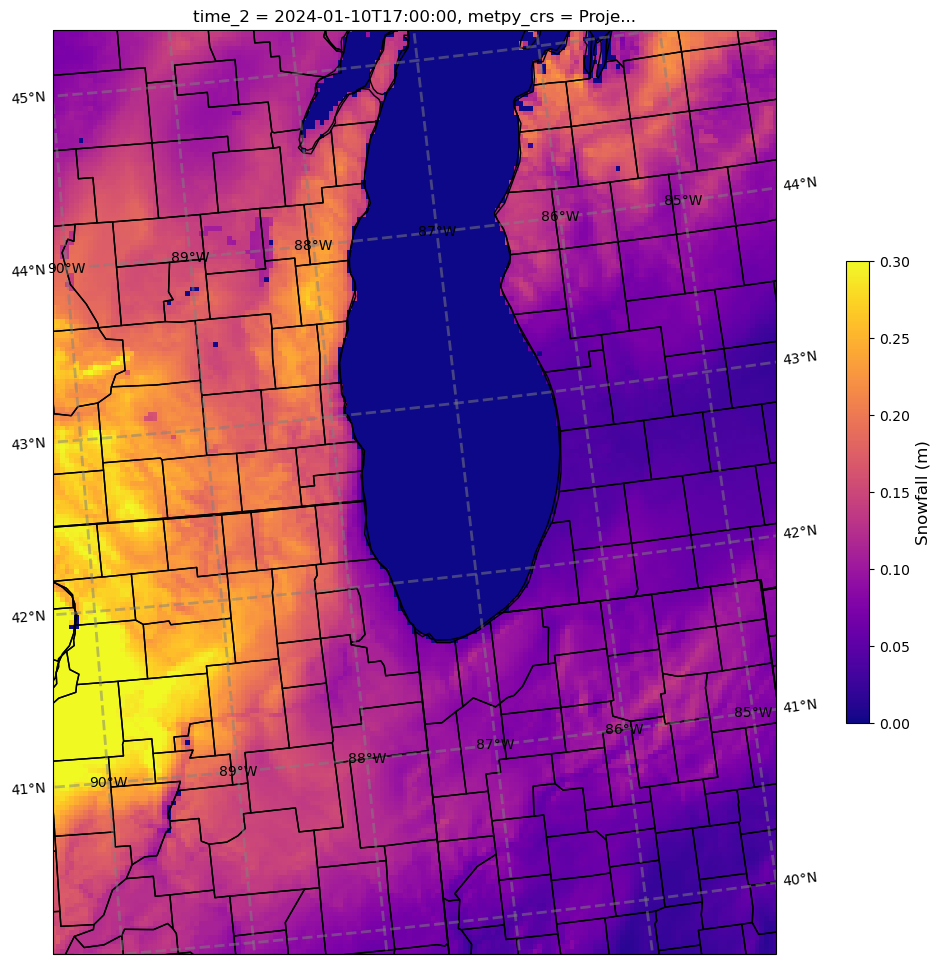

In [97]:
latN = 45.
latS = 40.
lonW = -90
lonE = -85

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
#tl1 = str('HRRR 2m temperature ($^\circ$C)')
#tl2 = str('Analysis valid at: '+ hour + '00 UTC ' + date  )
#plt.title(tl1+'\n'+tl2,fontsize=16)

# Contour fill
CF = ds.ASNOW_acc_fcst[-1].plot(add_colorbar=False, vmin = 0, vmax=0.3, cmap = 'plasma')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')


ax.add_feature(USCOUNTIES.with_scale('20m'))
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label(r'Snowfall (m)', size='large')

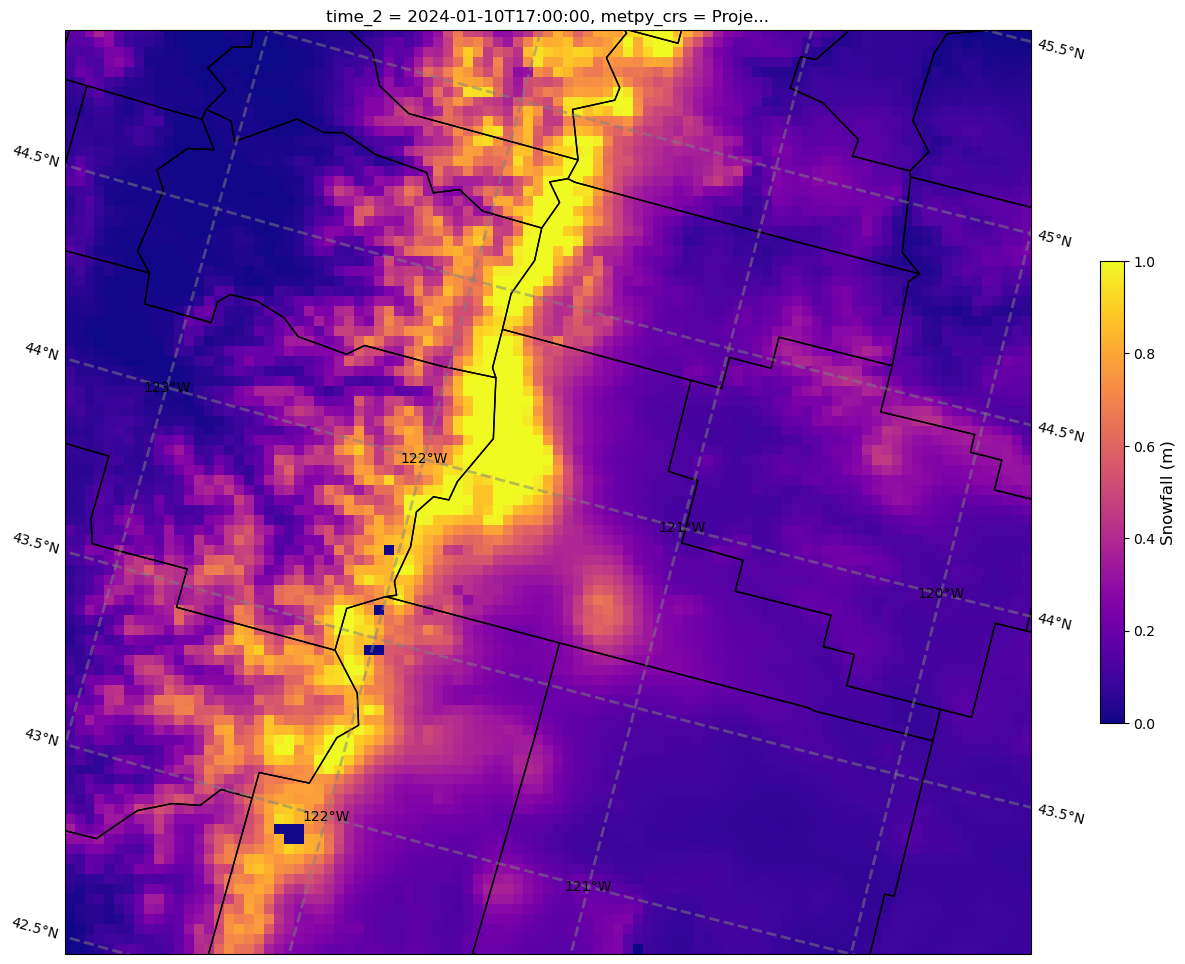

In [98]:
latN = 45.
latS = 43.
lonW = -123
lonE = -120

res = '50m'

fig = plt.figure(figsize=(18,12))
ax = plt.subplot(1,1,1,projection=projection)
ax.set_extent ([lonW,lonE,latS,latN],crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))

# Add the title
#tl1 = str('HRRR 2m temperature ($^\circ$C)')
#tl2 = str('Analysis valid at: '+ hour + '00 UTC ' + date  )
#plt.title(tl1+'\n'+tl2,fontsize=16)

# Contour fill
CF = ds.ASNOW_acc_fcst[-1].plot(add_colorbar=False, vmin = 0, vmax=1., cmap = 'plasma')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')


ax.add_feature(USCOUNTIES.with_scale('20m'))
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig.colorbar(CF,shrink=0.5)
cbar.set_label(r'Snowfall (m)', size='large')

In [87]:
argonne = [[-87.9789, 41.7183]] 
ts_ds = nearest_points(ds, argonne)

In [88]:
ts_ds

<xarray.Dataset>
Dimensions:                  (point: 1, time_2: 45)
Coordinates:
    x                        float64 7.915e+05
    y                        float64 3.987e+05
  * time_2                   (time_2) datetime64[ns] 2024-01-08T14:00:00 ... ...
    metpy_crs                object Projection: lambert_conformal_conic
    latitude                 float64 41.71
    longitude                float64 -87.96
Dimensions without coordinates: point
Data variables:
    ASNOW_acc_fcst           (point, time_2) float16 dask.array<chunksize=(1, 45), meta=np.ndarray>
    forecast_period_2        (point, time_2) datetime64[ns] dask.array<chunksize=(1, 45), meta=np.ndarray>
    forecast_reference_time  (point) datetime64[ns] 2024-01-08T12:00:00

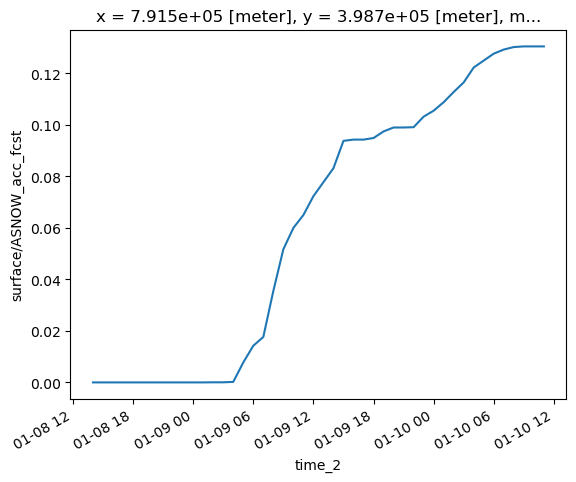

In [89]:
ts_ds.ASNOW_acc_fcst.plot()

In [ ]:
plt.ylim(43,45.)
plt.xlim(-123,-120)


In [22]:
fs = s3fs.S3FileSystem(anon=True)   
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))
chunk_index

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y           (y) float64 -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
Data variables:
    chunk_id    (x, y) object dask.array<chunksize=(225, 265), meta=np.ndarray>
    chunk_x     (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    chunk_y     (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    in_chunk_x  (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    in_chunk_y  (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    index_x     (x) int32 dask.array<chunksize=(1799,), meta=np.ndarray>
    index_y     (y) int32 dask.array<chunksize=(1059,), meta=np.ndarray>
    latitude    (y, x) float64 dask.array<chunksize=(133, 450), meta=np.ndarray>
    longitude   (y, x) float64 dask.array<chunksize=(133, 450), meta=np.ndarray>

In [23]:
lat_top = 39
lat_bottom = 34
lon_top = -107
lon_bottom = -110 # Four Corners region

def check_boundaries(data):
    return (lat_bottom < data.latitude) & (data.latitude < lat_top) & (
        lon_bottom < data.longitude) & (data.longitude < lon_top)

area = chunk_index.where(check_boundaries, drop=True)
area
# https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/python_data_loading.html

KeyboardInterrupt: 

In [ ]:
def get_unique(data):
    # We have to implement our own "unique" logic since missing values are NaN (a float) and the rest are string
    data = data.fillna(None).values.flatten()
    data = data[data != None]
    return np.unique(data)

chunk_ids = get_unique(area.chunk_id)

def get_chunk(zarr_id, chunk_id):
    # retrieve data as before
    compressed_data = retrieve_object(s3, create_s3_chunk_url(zarr_id, chunk_id))
    chunk_data = decompress_chunk(zarr_id, compressed_data)
    
    # combine retrieved data with the chunk grid
    chunk_xarray = chunk_index.where(lambda x: x.chunk_id == chunk_id, drop=True)
    dimensions = ("y", "x") if zarr_id.model_type == "anl" else ("time", "y", "x")
    chunk_xarray[zarr_id.var_name] = (dimensions, chunk_data)
    return chunk_xarray

def get_chunks_combined(zarr_id, chunk_ids):
    chunks = [get_chunk(zarr_id, chunk_id) for chunk_id in chunk_ids]
    return xr.merge(chunks)

    
data = get_chunks_combined(zarr_id, chunk_ids)
data